# Spatio Temporal Gaussian Processing

In [ ]:
!pip install gpflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.8/376.8 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 4.5 MB/s eta 0:00:00


In [ ]:
#imports

#basics
import numpy as np
import pandas as pd
import time
import scipy as sp
import sys
import tensorflow as tf
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


#cleaning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#viz
import h5py
import matplotlib.pyplot as plt
import seaborn as sns

#metrics
from scipy.cluster.vq import kmeans2
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

#Spatio-Temporal GP
import gpflow
from gpflow.optimizers import NaturalGradient
from gpflow.utilities import set_trainable, leaf_components

#unknown use
# import xarray as xr
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn import tree
# from sklearn.tree import DecisionTreeRegressor

## Get Data

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#paths
mainPath = '/content/drive/MyDrive/REU 2023 Team 1: Ice Bed Topography Prediction/Research/Yi_Work/'

data_full_ = mainPath + '/Data/data_full.csv' #training and test combined

data_1201_ = mainPath + '/Data/df_1201_validation_data.csv'

In [ ]:
#read data in
# df_train = pd.read_csv(df_train_)
# df_test_x = pd.read_csv(df_test_)
# df_test_y = pd.read_csv(df_pred_)

df_all = pd.read_csv(data_full_)

df1201 = pd.read_csv(data_1201_)

## Create functions from Homayra

In [ ]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(((y_true - y_pred) / y_true))))*100

In [ ]:
def rmspe_1(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(y_true - y_pred) / y_true))*100

## Clean Data/Prepare Data

In [ ]:
df_all = df_all.dropna()
df1201 = df1201.dropna()

df_all = df_all.drop_duplicates()
df1201 = df1201.drop_duplicates()

In [ ]:
df1201 = df1201.drop(columns = ['Unnamed: 0'])
df_all = df_all.drop(columns = ['Unnamed: 0'])

In [ ]:
#compute vmag to match final process for result comparison.
df_all['v_mag'] = np.sqrt(df_all['surf_vx']**2 + df_all['surf_vy']**2)
df1201['v_mag'] = np.sqrt(df1201['surf_vx']**2 + df1201['surf_vy']**2)

In [ ]:
#1201 drop location variables
df1201_feats = df1201.drop(columns = ['surf_x', 'surf_y'])

In [ ]:
#df_all drop location variables
df_all_feats_target = df_all.drop(columns = ['surf_x', 'surf_y', 'track_bed_x', 'track_bed_y'])

In [ ]:
#1201 order to align with df_all
df1201_feats_ordered = df1201_feats[['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB','v_mag']]

In [ ]:
#set the feature variables to our independent characteristic variables
feature_cols = ['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB','v_mag']

In [ ]:
#split into X and Y
X_given = df_all_feats_target[feature_cols]
Y_given = df_all_feats_target['track_bed_target']

In [ ]:
#combine all known X and validation 1201 X for standardizing
X_all = np.concatenate((X_given, df1201_feats_ordered))

In [ ]:
#make y into a dataframe to be standardized
Y_all = pd.DataFrame(Y_given)

In [ ]:
# #standardize
# #Not setting feature range, let it be automatically determined
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_all_std = scaler_X.fit_transform(X_all)
Y_all_std = scaler_Y.fit_transform(Y_all)

# #can alternatively use the MinMaxScaler

In [ ]:
#split of 1201 data from X_all_std
X_non1201 = X_all_std[0:632706,:]
X_1201_data = X_all_std[632706:, :]

In [ ]:
#generate a randomseed for training and testing split
generated = 168
print(generated)

168


In [ ]:
#set the train-test split
#60-40 showed the most promising from previous research
train_size_ = .9

In [ ]:
#split training and test from df_all
x_train, x_test, y_train, y_test = train_test_split(X_non1201, Y_all_std, train_size = train_size_, test_size = 1-train_size_, random_state = generated)
#get validation data
val_split = .2 #can change as needed
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 1-val_split, test_size = val_split, random_state = generated)

## Modeling

Code From: https://github.com/AaltoML/spatio-temporal-GPs/blob/main/experiments/nyc_crime/models/m_gpflow.py

In [ ]:
epochs=15

In [ ]:
x_train.shape

(455548, 6)

In [ ]:
%%time
#kernel_lengthscales = [0.001, 0.1, 0.1, 1, 100]
kernel_lengthscales = [1,1,1,1,1,1]
kernel_variances = 1.0
train_z = True
step_size = 0.01
# jitter = 1e-4
natgrad_step_size = 0.1
# enforce_psd = False
minibatch_size = 1500
binsize = 10
# Number of inducing points for gaussian process
num_z = 500

N, D = x_train.shape

# Get the trainable params associated with a gp model
def get_gpflow_params(m):
    params = {}
    leafs = leaf_components(m) # Leaf components represent nodes with traininable parameters
    for key in leafs.keys():
        tf_vars = leafs[key].trainable_variables

        # check if variable exists
        if len(tf_vars) == 1:
            tf_var = tf_vars[0]

            params[key] = tf_var.numpy()

    return params

print('num_z: ', num_z)

# Keep trying to group into k clusters until succesfully do so without creating any empty clusters
Z_all = None
while(True):

  Z_all = kmeans2(x_train, num_z, minit="points")[0]
  # Check for empty clusters
  unique_labels, counts = np.unique(Z_all, return_counts=True)
  empty_clusters = unique_labels[counts == 0]

  if len(empty_clusters) > 0:
      print("Empty clusters exist.")
      # Handle empty clusters as needed
      continue
  else:
      print("No empty clusters.")
      break

kernel = gpflow.kernels.Matern32

k = None
for d in range(D):
    # print(d, kernel_lengthscales)
    if type(kernel_lengthscales) is list:
        k_ls = kernel_lengthscales[d]
    else:
        k_ls = kernel_lengthscales

    if type(kernel_variances) is list:
        k_var = kernel_variances[d]
    else:
        k_var = kernel_variances

    k_d = kernel(
        lengthscales=[k_ls],
        variance=k_var,
        active_dims=[d]
    )

    # print(k_d)
    if k is None:
        k = k_d
    else:
        k = k * k_d

init_as_cvi = True

if init_as_cvi:
    M = Z_all.shape[0]
    jit = 1e-6

    Kzz = k(Z_all, Z_all)

    def inv(K):
        K_chol = sp.linalg.cholesky(K + jit * np.eye(M), lower=True)
        return sp.linalg.cho_solve((K_chol, True), np.eye(K.shape[0]))

    # manual q(u) decompositin
    nat1 = np.zeros([M, 1])
    nat2 = -0.5 * inv(Kzz)

    lam1 = 1e-5 * np.ones([M, 1])
    lam2 = -0.5 * np.eye(M)

    S = inv(-2 * (nat2 + lam2))
    m = S @ (lam1 + nat1)

    S_chol = sp.linalg.cholesky(S + jit * np.eye(M), lower=True)
    S_flattened = S_chol[np.tril_indices(M, 0)]

    q_mu = m
    q_sqrt = np.array([S_chol])
else:
    q_mu = 1e-5 * np.ones([Z_all.shape[0], 1])  # match gpjax init
    q_sqrt = None

lik = gpflow.likelihoods.Poisson(binsize=binsize)

data = (x_train, y_train)

m = gpflow.models.SVGP(
    inducing_variable=Z_all,
    whiten=True,
    kernel=k,
    mean_function=None,
    likelihood=lik,
    q_mu=q_mu,
    q_sqrt=q_sqrt
)

set_trainable(m.inducing_variable, True)

num_z:  500


/usr/local/lib/python3.10/dist-packages/scipy/cluster/vq.py:602: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


No empty clusters.
CPU times: user 14.1 s, sys: 8.41 s, total: 22.6 s
Wall time: 21.2 s


In [ ]:
def _prediction_fn(X_, Y_):
    mu, var = m.predict_y(X_)
    # print("predictions.shape:", mu.shape)
    log_pred_density = m.predict_log_density((X_, Y_))
    return mu.numpy(), var.numpy(), log_pred_density.numpy()

In [ ]:
%%time
# ===========================Train===========================


if minibatch_size is None or minibatch_size is 'none':
    training_loss = m.training_loss_closure(data)
else:
    # print(N, minibatch_size)
    train_dataset = (tf.data.Dataset.from_tensor_slices(data).repeat().shuffle(N).batch(minibatch_size))
    train_iter = iter(train_dataset)
    training_loss = m.training_loss_closure(train_iter)

# make it so adam does not train these
set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

natgrad_opt = NaturalGradient(gamma=natgrad_step_size)
natgrad_opt._name = "test" # This line has to be here, because tensorflow expects the existence of a _name attribute, which the current version of NaturalOptimizer does not assign
print(natgrad_opt)
print(natgrad_opt.minimize)
variational_params = [(m.q_mu, m.q_sqrt)]

#print('variational_params ', variational_params)
optimizer = tf.optimizers.Adam
adam_opt_for_vgp = optimizer(step_size)

training_loss_plot = pd.DataFrame(columns = ["epoch", "loss"])
loss_arr = []

bar = tqdm(total=epochs)

testing_loss_plot = pd.DataFrame(columns = ["epoch", "loss"])

# MINIBATCHING TRAINING
t0 = time.time()
for i in range(epochs):
    # NAT GRAD STEP
    natgrad_opt.minimize(training_loss, var_list=variational_params)

    # ADAM STEP
    adam_opt_for_vgp.minimize(training_loss, var_list=m.trainable_variables)

    #training loss
    training_loss_value = float(training_loss())
    training_loss_plot = training_loss_plot.append({"epoch": i, "loss": training_loss_value}, ignore_index=True)

    #testing loss
    _, _, log_pred_density = _prediction_fn(x_test, y_test)
    testing_loss_value = -np.mean(log_pred_density)
    testing_loss_plot = testing_loss_plot.append({"epoch": i, "loss": testing_loss_value}, ignore_index=True)

    #update
    bar.update(1)

t1 = time.time()
avg_time_taken = (t1-t0)/epochs
print('average iter time: %2.2f secs' % avg_time_taken)

<bound method NaturalGradient.minimize of <gpflow.optimizers.natgrad.NaturalGradient object at 0x7ab8fc5eec80>>


<timed exec>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
  0%|          | 0/15 [00:00<?, ?it/s]WARNING:tensorflow:5 out of the last 5 calls to <function _BaseOptimizer._update_step_xla at 0x7ab8fcb4aa70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
<timed exec>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:49: FutureWarning: The frame.append method is deprec

average iter time: 2.59 secs
CPU times: user 24.2 s, sys: 1.14 s, total: 25.3 s
Wall time: 39 s


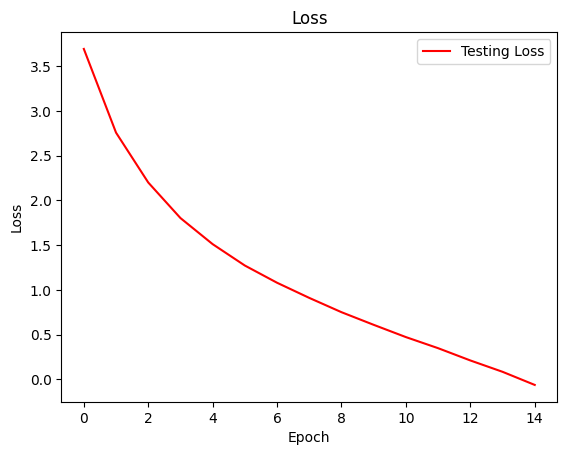

In [ ]:
# plt.plot(training_loss_plot["epoch"], training_loss_plot["loss"], label="Training Loss", color = "blue")
plt.plot(testing_loss_plot["epoch"], testing_loss_plot["loss"], label="Testing Loss", color = "red")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.show()

In [ ]:
%%time
print('predicting...')
posterior_mean, posterior_var, lpd = _prediction_fn(x_test, y_test)
# print(lpd.shape)
# print(lpd)
#nlpd = np.mean(-lpd)
rmse = np.sqrt(np.nanmean((np.squeeze(y_test) - np.squeeze(posterior_mean))**2))
#print('nlpd: %2.3f' % nlpd)
print('rmse: %2.3f' % rmse)


predicting...
rmse: 1.255
CPU times: user 683 ms, sys: 22.8 ms, total: 706 ms
Wall time: 1.33 s


In [ ]:
y_predict, variance = m.predict_y(x_test)
y_predict = np.asarray(y_predict)
# print(y_predict)

In [ ]:
#get the original scale for the predicted Y
train_predict_full_scale = scaler_Y.inverse_transform(y_train.reshape(-1,1))
test_predict_full_scale = scaler_Y.inverse_transform(y_predict.reshape(-1,1))
y_test_given_full_range = scaler_Y.inverse_transform(y_test.reshape(-1,1))

In [ ]:
# Evaluate the model performance

#LOSSES
print('RMSE:',np.sqrt(mean_squared_error(y_test_given_full_range, test_predict_full_scale)))
print('RMSE Percentage:',rmspe(y_test_given_full_range, test_predict_full_scale))
print('RMSE Percentage-1:',rmspe_1(y_test_given_full_range, test_predict_full_scale))
print('Mean Absolute Error:', mean_absolute_error(y_test_given_full_range, test_predict_full_scale))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test_given_full_range, test_predict_full_scale))
print('R^2 Score:', r2_score(y_test_given_full_range, test_predict_full_scale))

RMSE: 225.771698454589
RMSE Percentage: 36436.320413547735
RMSE Percentage-1: 618.0922588801812
Mean Absolute Error: 126.81922078268724
Mean Absolute Percentage Error: 4.440033731170968
R^2 Score: -0.5799409065142862


# 1201 Runs Out of Space with the Resources Exhausted Error.